In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

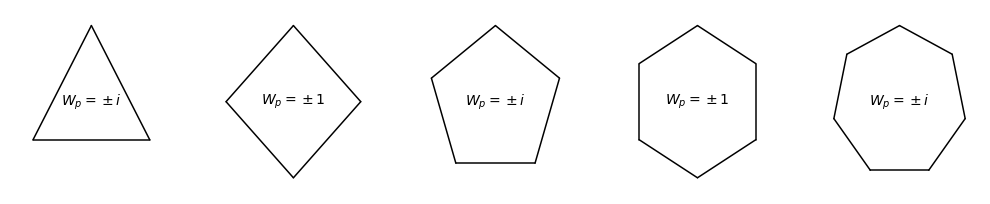

In [4]:
import matplotlib.pyplot as plt
from koala import plotting as pl
from koala import example_graphs as eg

Ns= [3,4,5,6,7]

w = 3.5
f, axes = plt.subplots(ncols = len(Ns), figsize = (w*len(Ns), w))

for n, ax in zip(Ns, axes):
    l = eg.single_plaquette(n)
    pl.plot_edges(l,ax = ax)
    ax.text(0.5,0.5, r"$W_p = \pm i$" if n%2 else r"$W_p = \pm 1$", ha = "center", va = "center", fontsize = 14)
    ax.axis("off")

In [ ]:
from dataclasses import dataclass
import numpy as np
import operator
import functools
import itertools as it

def product(iterable): return functools.reduce(operator.mul, iterable, 1)
def factorial(n): return product(range(1,n+1))
def commutator(a,b): return a@b - b@a

def epsilon(*args):
    n = len(args)
    return product(
        product(args[j] - args[i] for j in range(i, n-1))
        // factorial(i) for i in range(n))

@dataclass
class Spin:
    """A spin represented by pauli matrices in the z basis"""
    x = np.array([[0,1],[1,0]])
    y = np.array([[0,-1j],[1j,0]])
    z = np.array([[1,0],[0,-1]])
    index = None
    
    def __getitem__(self, key):
        return np.array([self.x,self.y,self.z])[key]
    
p = Spin()
# Check [sigma_a, sigma_a] = 0
for i in range(3): assert np.allclose(commutator(p[i], p[i]), 0)

# for i, j, k in it.product(range(3), repeat = 3):
#     print((i,j), commutator(p[i], p[j]) - 2 * sum(epsilon(i,j,k) * p[k] for k in range(3)))


In [ ]:
from koala import plotting as pl
from koala import example_graphs as eg
from koala.flux_finder import pathfinding

import functools

rng = np.random.default_rng(seed = 10)
l, coloring, _ = eg.make_amorphous(8, rng = rng)

f, ax = plt.subplots(figsize = (10,10))


# pl.plot_vertex_indices(l, ax = ax)
# pl.plot_edge_indices(l, ax = ax)
# pl.plot_plaquette_indices(l, ax = ax)

vertices, edges = pathfinding.path_between_vertices(l, 24, 53)
vertices, edges2 = pathfinding.path_between_vertices(l, 23, 53)

noncontractible_loop = edges + edges2 + [157,]

plaquettes = [40, 52, 41, 43, 53, 30]
W_p = list(functools.reduce(lambda a,b: a^b, [set(l.plaquettes[i].edges) for i in plaquettes]))
print(W_p)

pl.plot_edges(l, ax = ax, alpha = 0.2)
pl.plot_edges(l, ax = ax, subset = noncontractible_loop, color = "r", label = "Non-contractible Loop")
pl.plot_edges(l, ax = ax, subset = W_p, color = "g", label = "$W_p$")
pl.plot_edges(l, ax = ax, subset = l.plaquettes[49].edges, color = "b", label = "$\Phi$")

ax.legend()
ax.set(xticks = [], yticks = [])

In [ ]:
#!/usr/bin/env python3

import matplotlib
from matplotlib.colors import to_rgba, to_hex
from matplotlib import cm
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.stats
from pathlib import Path

from koala import plotting as pl
from koala import phase_diagrams as pd
from koala import pointsets, voronization, flux_finder, graph_color
from koala import example_graphs as eg

# imports just for this plot
# import custom_voronization as voronization
from scipy.spatial import Voronoi, voronoi_plot_2d

column_width = 3.375
w = 3.375
black_line_widths = 1.2

matplotlib.rcParams.update({'font.size': 13, 'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern']})
matplotlib.rcParams.update({"axes.linewidth": black_line_widths})

# Modified RGB color scheme
bond_colors = """" 
#e41a1c
#4daf4a
#00639a
""".split()[1:]

line_colors = [to_hex(a) for a in cm.inferno([0.25, 0.5, 0.75])]
grid_style = dict(linewidths = black_line_widths, linestyle = '-', colors = 'k', alpha = 0.2)

cmap = plt.get_cmap("tab10")
color_scheme = cmap([0,1])

from koala.flux_finder.flux_finder import _greedy_plaquette_pairing
from koala.flux_finder.pathfinding import straight_line_length, periodic_straight_line_length
from koala.flux_finder.flux_finder import _flip_adjacent_fluxes

rng = np.random.default_rng(222424252565)
lattice, colouring, gs_ujk = eg.make_amorphous(8, rng = rng)
# random_ujk = rng.choice([+1, -1], size = gs_ujk.shape)
gs_fluxes = flux_finder.fluxes_from_bonds(lattice, gs_ujk)

better_ujk, better_fluxes = _flip_adjacent_fluxes(lattice, gs_ujk.copy(), gs_fluxes.copy())




def panel_a(ax):
    pl.plot_edges(lattice, ax = ax, directions = gs_ujk, linewidths = 1)
    pl.plot_plaquettes(lattice, labels = (gs_fluxes == +1), ax = ax, color_scheme = color_scheme, alpha = 0.5)
    
def panel_b(ax):
    
    def plaquette_metric(l):
        def d(a,b): return straight_line_length(l.plaquettes[a].center, l.plaquettes[b].center)
        return d

    def plot_bad_flux_pairing(l, bonds, fluxes, ax):
        bad_fluxes = np.nonzero(fluxes == -1)[0]
        pairs = _greedy_plaquette_pairing(bad_fluxes, distance_func = plaquette_metric(l))

        fluxes = flux_finder.fluxes_from_bonds(l, bonds)
        plaquette_labels = (fluxes == +1)
        pl.plot_plaquettes(l, plaquette_labels, color_scheme = color_scheme, ax = ax, alpha = 0.2)

        pl.plot_edges(l, alpha = 0.2, ax = ax)

        def pos(i): return l.plaquettes[i].center
        lines = [[pos(a),pos(b)] for a,b in pairs]

        from matplotlib.collections import LineCollection
        lines = LineCollection(lines, color = 'k')
        ax.add_collection(lines)

        return pairs
    
    return plot_bad_flux_pairing(lattice, better_ujk, better_fluxes, ax)

def panel_c(ax, pairs):
    path_kw = dict(heuristic = straight_line_length)
    
    def plot_paths(l, fluxes, pairs, ax):
        # pl.plot_plaquettes(l, fluxes == +1, color_scheme = color_scheme, ax = ax, alpha = 0.1)
        pl.plot_edges(l, alpha=0.2, ax = ax)

        plaquette_paths, edge_paths = zip(*(pathfinding.path_between_plaquettes(l, a, b, **path_kw) for a,b in pairs))

        for plaqs, edges in zip(plaquette_paths, edge_paths):
            print(plaqs)
            color = cmap(rng.integers(10))
            pl.plot_plaquettes(l, subset=plaqs, color_scheme= [color,], ax=ax, alpha = 0.5)
            pl.plot_edges(l, subset=edges, color = 'black', ax=ax)

        return edge_paths
    plot_paths(lattice, fluxes, pairs, ax)
    
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(2 * w, 2/3 * w)

panel_a(axes[0])
pairs = panel_b(axes[1])
panel_c(axes[2], pairs)
for ax in axes: ax.set(xticks = [], yticks = [])


fig.tight_layout()



Mx, My = (-1, -1)
Mx, My = (1, 1)


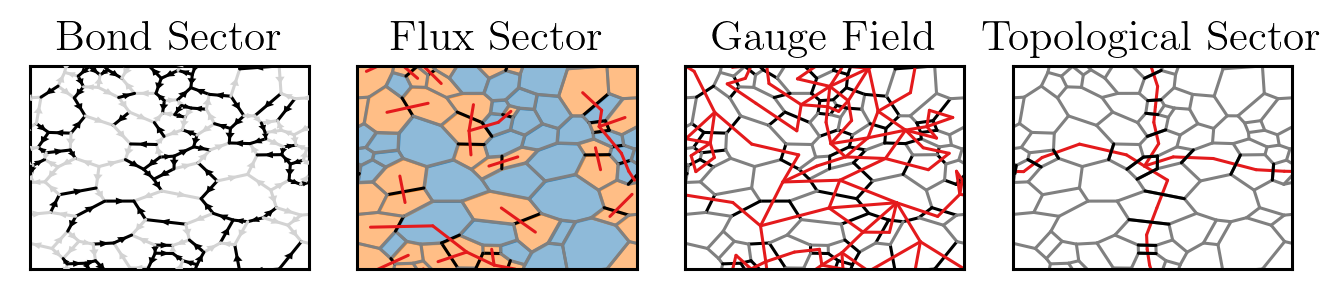

In [6]:
#!/usr/bin/env python3

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

import matplotlib
from matplotlib.colors import to_rgba, to_hex
from matplotlib import cm
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.stats
from pathlib import Path

from koala import plotting as pl
from koala import phase_diagrams as pd
from koala import pointsets, voronization, flux_finder, graph_color
from koala import example_graphs as eg
from koala import graph_utils

# imports just for this plot
column_width = w = 3.375
black_line_widths = 1.1

matplotlib.rcParams.update({'font.size': 13, 'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern']})
matplotlib.rcParams.update({"axes.linewidth": black_line_widths})

# Modified RGB color scheme
bond_colors = """" 
#e41a1c
#4daf4a
#00639a
""".split()[1:]

line_colors = [to_hex(a) for a in cm.inferno([0.25, 0.5, 0.75])]
grid_style = dict(linewidths = black_line_widths, linestyle = '-', colors = 'k', alpha = 0.2)

cmap = plt.get_cmap("tab10")
color_scheme = cmap([0,1])

rng = np.random.default_rng(222424252565)
lattice, colouring, ujk_ground_state = eg.make_amorphous(8, rng = rng)
# lattice, colouring, ujk_ground_state = eg.make_honeycomb(7)

ground_state_fluxes = flux_finder.fluxes_from_bonds(lattice, ujk_ground_state)

#create a bond_sector state in the bond sector
bond_sector_ujk = rng.choice([+1, -1], size = ujk_ground_state.shape)
bond_sector_fluxes = flux_finder.fluxes_from_bonds(lattice, bond_sector_ujk)

# create a reference state to fix the gauge
reference_ujk = np.ones_like(bond_sector_ujk)
reference_fluxes = flux_finder.fluxes_from_bonds(lattice, reference_ujk)

# construct the bond_sector state using just MSP bond flips from the reference
# possibly in a different gauge sector and/or topological sector
flux_sector_ujk = flux_finder.find_flux_sector(lattice, bond_sector_fluxes, reference_ujk)
flux_sector_fluxes = flux_finder.fluxes_from_bonds(lattice, flux_sector_ujk)

# Construct the gauge sector, this is just the difference between
# the bond sector and the flux
gauge_sector_ujk = bond_sector_ujk * flux_sector_ujk
gauge_sector_fluxes = flux_finder.fluxes_from_bonds(lattice, gauge_sector_ujk)
assert(np.all(np.equal(bond_sector_fluxes, flux_sector_fluxes)))

## Construct the topological sector
verts_x, Px, dir_x = pathfinding.graph_loop(lattice, direction = "x")
verts_y, Py, dir_y = pathfinding.graph_loop(lattice, direction = "y")

plaqs_x, Tx = pathfinding.dual_loop(lattice, direction = "x")
plaqs_y, Ty = pathfinding.dual_loop(lattice, direction = "y")

def measure(ujk, edges, directions):
    return np.product(ujk[edges] * directions)

Mx = measure(gauge_sector_ujk, Px, dir_x)
My = measure(gauge_sector_ujk, Py, dir_y)
print(f"Mx, My = {Mx, My}")

topological_sector_ujk = np.ones_like(bond_sector_ujk)

if Mx == -1: 
    gauge_sector_ujk[Ty] *= -1
    topological_sector_ujk[Ty] *= -1
    
if My == -1: 
    gauge_sector_ujk[Tx] *= -1
    topological_sector_ujk[Tx] *= -1

topological_sector_fluxes = flux_finder.fluxes_from_bonds(lattice, topological_sector_ujk)
    
Mx = measure(gauge_sector_ujk, Px, dir_x)
My = measure(gauge_sector_ujk, Py, dir_y)
print(f"Mx, My = {Mx, My}")

assert(all(np.equal(bond_sector_ujk, flux_sector_ujk * gauge_sector_ujk * topological_sector_ujk * reference_ujk)))

ncols = 4
fig, axes = plt.subplots(nrows=1, ncols=ncols)
fig.set_size_inches(2 * w, 2/ncols * w)

ax = axes[0]
pl.plot_edges(lattice, directions = bond_sector_ujk, 
              labels = (bond_sector_ujk != reference_ujk),
              color_scheme = ['lightgrey', 'black'],
              ax = ax, linewidths = black_line_widths, 
             )

ax = axes[1]
pl.plot_edges(lattice, labels = (flux_sector_ujk != reference_ujk),
              ax = ax, linewidths = black_line_widths,
              color_scheme = ['grey', 'black'])

pl.plot_plaquettes(lattice, labels = (flux_sector_fluxes != reference_fluxes),
                   color_scheme = color_scheme, ax = ax, alpha = 0.5)

flipped_edges = (flux_sector_ujk != reference_ujk)
pl.plot_dual(lattice, subset = flipped_edges, ax = ax, linewidths = black_line_widths, color_scheme = bond_colors)

ax = axes[2]

pl.plot_edges(lattice, labels = (gauge_sector_ujk != reference_ujk),
              ax = ax, linewidths = black_line_widths,
              color_scheme = ['grey', 'black'])

flipped_edges = (gauge_sector_ujk != reference_ujk)
pl.plot_dual(lattice, subset = flipped_edges, ax = ax,
             linewidths = black_line_widths, color_scheme = bond_colors)

pl.plot_plaquettes(lattice, labels = (gauge_sector_fluxes != reference_fluxes),
                   color_scheme = ['white', 'red'], ax = ax, alpha = 0.5)

ax = axes[3]
pl.plot_edges(lattice, ax = ax, linewidths = black_line_widths, color = 'grey')

# pl.plot_plaquettes(lattice, subset = plaqs_x, color = 'grey', alpha = 0.5)
# pl.plot_dual(lattice, subset = Tx)
# pl.plot_edges(lattice, subset = Tx)

# pl.plot_edges(lattice, subset = Py, directions = dir_y)

pl.plot_plaquettes(lattice, labels = (topological_sector_fluxes != reference_fluxes),
                   color_scheme = ['white', 'red'], ax = ax, alpha = 0.5)

flipped_edges = (topological_sector_ujk != reference_ujk)
if np.any(flipped_edges):
    pl.plot_dual(lattice, subset = flipped_edges, ax = ax, linewidths = black_line_widths, color_scheme = bond_colors)
    pl.plot_edges(lattice, subset = flipped_edges, ax = ax, linewidths = black_line_widths, color = 'k')


for ax in axes: ax.set(xticks = [], yticks = [])

axes[0].set(title = "Bond Sector")
axes[1].set(title = "Flux Sector")
axes[2].set(title = "Gauge Field")
axes[3].set(title = "Topological Sector")

fig.tight_layout()

In [ ]:
rng = np.random.default_rng(222424252565)
lattice, colouring, ujk_ground_state = eg.make_amorphous(8, rng = rng)    

ncols = 4
fig, axes = plt.subplots(nrows=1, ncols=ncols)
fig.set_size_inches(2 * w, 2/ncols * w)

for ax in axes: ax.set(xticks = [], yticks = [])

ax = axes[0]
v, e = graph_loop(lattice, direction = "x")
print(v)
pl.plot_edges(lattice, ax = ax, linewidths = black_line_widths, color = 'grey')
pl.plot_edges(lattice, subset = e, ax = ax)

ax = axes[1]
v, e = graph_loop(lattice, direction = "y")
print(v)
pl.plot_edges(lattice, ax = ax, linewidths = black_line_widths, color = 'grey')
pl.plot_edges(lattice, subset = e, ax = ax)

ax = axes[2]
p, e = dual_loop(lattice, direction = "x")
print(v)
pl.plot_edges(lattice, ax = ax, linewidths = black_line_widths, color = 'grey')
pl.plot_plaquettes(lattice, ax = ax, subset = p, alpha = 0.5)
pl.plot_dual(lattice, subset = e, ax = ax)

ax = axes[3]
p, e = dual_loop(lattice, direction = "y")
print(v)
pl.plot_edges(lattice, ax = ax, linewidths = black_line_widths, color = 'grey')
pl.plot_plaquettes(lattice, ax = ax, subset = p, alpha = 0.5)
pl.plot_dual(lattice, subset = e, ax = ax)


# pl.plot_plaquettes(lattice, subset = p, ax = ax)
# pl.plot_edges(lattice, subset = e, ax = ax)
# pl.plot_dual(lattice, subset = e, ax = ax)


In [43]:
from koala import graph_utils as gu
from koala import hamiltonian
import pickle

J = np.array([1,1,1])
L = 50

rng = np.random.default_rng()
lattice, colouring, ujk = eg.make_amorphous(L, rng = rng)
gs_flux_sector = flux_finder.fluxes_from_bonds(lattice, ujk)

a, b = gu.closest_plaquette(lattice, [0.33, 0.5]), gu.closest_plaquette(lattice, [0.66, 0.5])
plaqs, edges = pathfinding.path_between_plaquettes(lattice, a, b)
ujk[edges] *= -1 
flux_sector = flux_finder.fluxes_from_bonds(lattice, ujk)

H = hamiltonian.generate_majorana_hamiltonian(lattice, colouring, ujk, J)
eigs, vecs = np.linalg.eigh(H)

idx = np.argsort(np.abs(eigs))
lowest_wavefunction = vecs[:, idx[0]]

data = dict(
    L = L,
    lattice = lattice,
    colouring = colouring,
    gs_flux_sector = gs_flux_sector,
    plaquettes = (a, b),
    plaquette_path = plaqs,
    edge_path = edges,
    
    ujk = ujk,
    J = J,
    
    ground_state_density = np.abs(lowest_wavefunction)
)

with open("solved_lattice.pickle", "wb") as f:
    pickle.dump(data, f)

TypeError: unsupported operand type(s) for ** or pow(): 'tuple' and 'int'

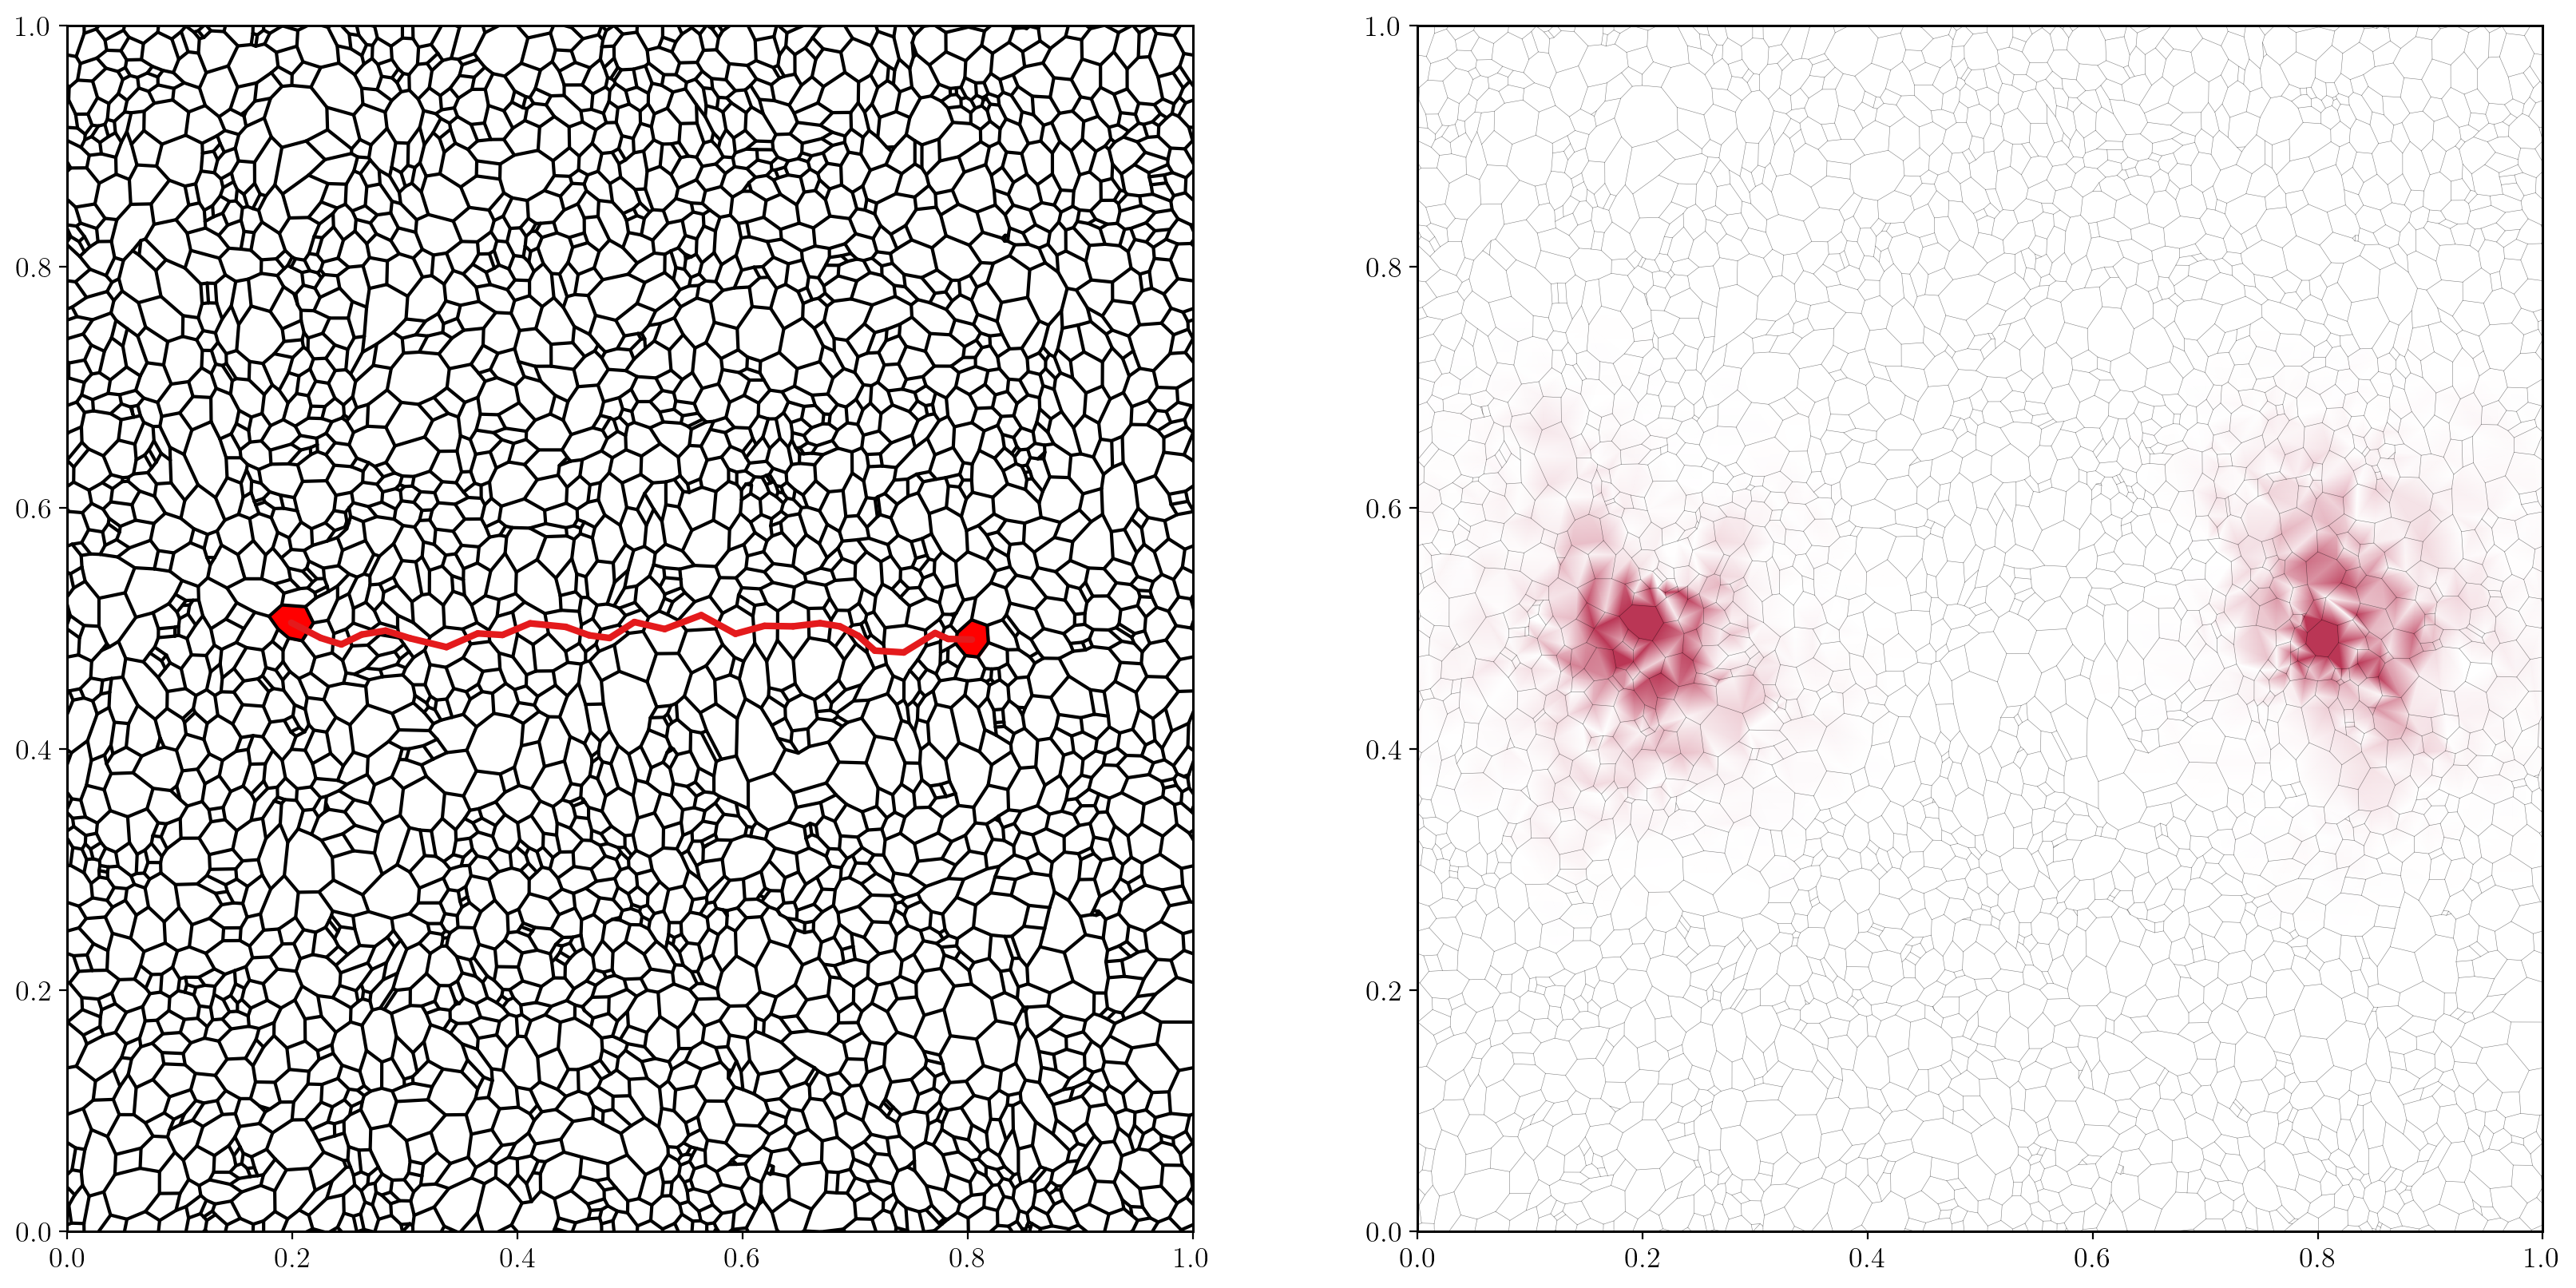

In [42]:
from matplotlib.colors import ListedColormap

with open("solved_lattice.pickle", "rb") as f:
    data = pickle.load(f)
    globals().update(data)

inferno = matplotlib.cm.get_cmap('inferno_r', 256)
newcolors = inferno(np.linspace(0.7, 0, 256))
white = np.array([1, 1, 1, 1])
newcolors[-1, :] = white
inferno_purple_to_white_cmap = ListedColormap(newcolors)

purple = inferno(0.5)
white = np.array([1,1,1,1])
t = np.linspace(0, 1, 256)[:, None]
newcolors = t * purple + (1-t) * white
plum_to_white_cmap = ListedColormap(newcolors)

f, axes = plt.subplots(ncols = 2, figsize = (20,10))

flux_sector = flux_finder.fluxes_from_bonds(ujk)

ax = axes[0]
pl.plot_edges(lattice, ax = ax)
pl.plot_plaquettes(lattice, subset = flux_sector != gs_flux_sector, ax = ax)
pl.plot_dual(lattice, subset = edge_path, linewidth = 3, ax = ax,
             color_scheme = bond_colors)

ax = axes[1]
pl.plot_edges(lattice, linewidth = 0.2, ax = ax, zorder = -1, alpha = 0.5)

ax.tripcolor(*lattice.vertices.positions.T, ground_state_density,
             cmap = plum_to_white_cmap,
             # cmap = 'inferno',
             shading = 'gouraud', 
             vmin = 0.001, vmax = 0.1,
             zorder = -2)


KeyError: 'highlighted_line'

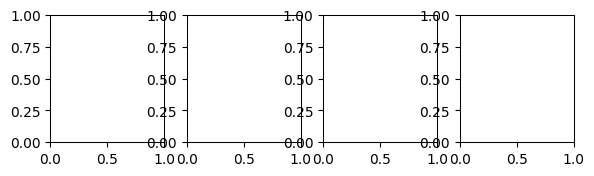

In [68]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import numpy as np
rng = np.random.default_rng(43245426246)

from matplotlib import pyplot as plt
import scipy
from scipy.linalg import eigvalsh, qr, eigh

import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['lines.linewidth'] = 0.75
matplotlib.rcParams['axes.linewidth'] = 0.75

from time import time
from mpire import WorkerPool
from scipy.stats import sem

import os

import koala

from koala import pointsets, voronization, graph_color, example_graphs, flux_finder, hamiltonian, graph_utils
from koala import plotting as pl
from koala.lattice import Lattice
from koala import example_graphs as eg
from koala import phase_space as ps
from koala.flux_finder import pathfinding

import pickle
from tqdm.notebook import tqdm
import itertools as it

import matplotlib.tri as mtri
from koala import hamiltonian, flux_finder
from koala import phase_diagrams as pd

def project_to_triangle(points): 
    skew = np.array([[1, np.cos(np.pi/3)],
                          [0, np.sin(np.pi/3)]])

    return np.einsum('ij,kj -> ki', skew, points[..., :2])


w = 3.375
ncols = 4
fig, axes = plt.subplots(nrows=1, ncols=ncols)
fig.set_size_inches(2 * w, 2/ncols * w)

ax = axes[0]

for i, (s, e) in enumerate(data['lines']):
    p = line(s, e, npoints = 20)
    ax.plot(*project_to_triangle(p).T, 
            color = 'r' if i == data['highlighted_line'] else 'k')
    
ax.axis('off')
pd.plot_triangle(ax)

for ax in axes: ax.set(xticks = [], yticks = [])

In [69]:
def line(start, end, npoints):
    t = np.linspace(0,1,npoints)[:, None]
    return start * (1-t) + end * t

symmetry_points = np.array([[0,0.5,0.5], [0.5,0,0.5], [0.5,0.5,0]])
center = np.array([1,1,1])/3
lines = []

triplets = np.array([
    [
    [0,0,1], #z
    [0, 0.5, 0.5],
    [0.5, 0, 0.5]
    ],
    [
    [0,1,0], #y
    [0.5, 0.5, 0],
    [0, 0.5, 0.5]
    ],
    [
    [1,0,0], #x
    [0.5, 0, 0.5],
    [0.5, 0.5, 0]
    ]
])

## User Parameters ### 
n_lines = 4
highlighted_line = 3
lattice, coloring, ujk, points = eg.make_amorphous(L = 15, return_points = True)

_, T_x = pathfinding.dual_loop(lattice, direction = 'x')
_, T_y = pathfinding.dual_loop(lattice, direction = 'y')


## End of user parameters

t = np.linspace(0,1,n_lines)[:, None]

logo_lines = []
for corner, left, right in triplets:
    line_ends = left * t + (1-t) * center
    line_ends2 = center * t + right * (1-t)
    line_ends = np.concatenate([line_ends2[:-1], line_ends])

    for e in line_ends:
        logo_lines.append([corner, e])
        
lines = np.array(logo_lines)

def gap_size_along_line(start_J, end_J, lattice, coloring, ujk): 
    def f(t):
        J = start_J * (1-t) + t * end_J
        maj_ham = hamiltonian.generate_majorana_hamiltonian(lattice, coloring, ujk, J)
        maj_energies = np.linalg.eigvalsh(maj_ham)
        return min(np.abs(maj_energies))
    return f
    
    
gap_vs_t = dict()

for x, y in it.product((0,1), repeat = 2): 
    this_ujk = ujk.copy()
    if x: this_ujk[T_x] *= -1
    if y: this_ujk[T_y] *= -1
    
    start_J, end_J = lines[highlighted_line]
    gap = gap_size_along_line(start_J, end_J, lattice, coloring, this_ujk)

    # phase_edge_t = pd.compute_phase_diagram(ts, gap, extra_args = {}, n_jobs = 7)
    gaps = np.array([gap(t) for t in ts])

    gap_vs_t[(1-2*x,1-2*y)] = gaps
    
data = dict(
    lines = lines,
    highlighted_line = highlighted_line,
    
    lattice = lattice,
    coloring = coloring,
    ujk = ujk,
    points = points,
    T_x = T_x,
    T_y = T_y,
    
    ts = ts,
    gap_vs_t = gap_vs_t,
)

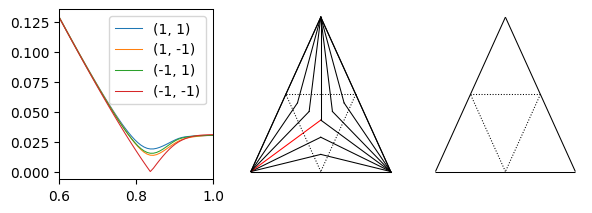

In [85]:
lines, highlighted_line, lattice, coloring, \
ujk, points, T_x, T_y, ts, gap_vs_t = data.values()

w = 3.375
ncols = 3
fig, axes = plt.subplots(nrows=1, ncols=ncols)
fig.set_size_inches(2 * w, 2/ncols * w)

ax = axes[1]

for i, (s, e) in enumerate(lines):
    p = line(s, e, npoints = 20)
    ax.plot(*project_to_triangle(p).T, 
            color = 'r' if i == highlighted_line else 'k')
    
ax.axis('off')
pd.plot_triangle(ax)

# ax = axes[1]
# pl.plot_edges(lattice, ax = ax, alpha = 0.5)
# pl.plot_edges(lattice, ax = ax, subset = list(set(T_x) | set(T_y)))

ax = axes[0]

for sector, gaps in gap_vs_t.items():
    ax.plot(ts, gaps, label = f"{sector}")
    
ax.set(xlim = (0.6, 1))
ax.legend()

ax = axes[2]
ax.axis('off')
pd.plot_triangle(ax)
ax.set(xlim = axes[1].get_xlim(), ylim = axes[1].get_ylim())

for ax in axes[[1,2]]: ax.set(xticks = [], yticks = [])

In [92]:
optimise_results = []
phase_edge_t = []
phase_edge_J = []
for start, end in tqdm(lines):
    objective = gap_size_along_line(start, end, lattice, coloring, ujk)
    out = scipy.optimize.minimize_scalar(objective, bounds=[0,1], method = 'Bounded', tol = 1e-4)
    t = out.x
    optimise_results.append(out)
    phase_edge_t.append(t)
    phase_edge_J.append(start * (1-t) + t * end)
    

phase_edge_t, phase_edge_J = np.array(phase_edge_t), np.array(phase_edge_J)

  0%|          | 0/21 [00:00<?, ?it/s]

In [93]:
phase_edge_J.shape

(21, 3)

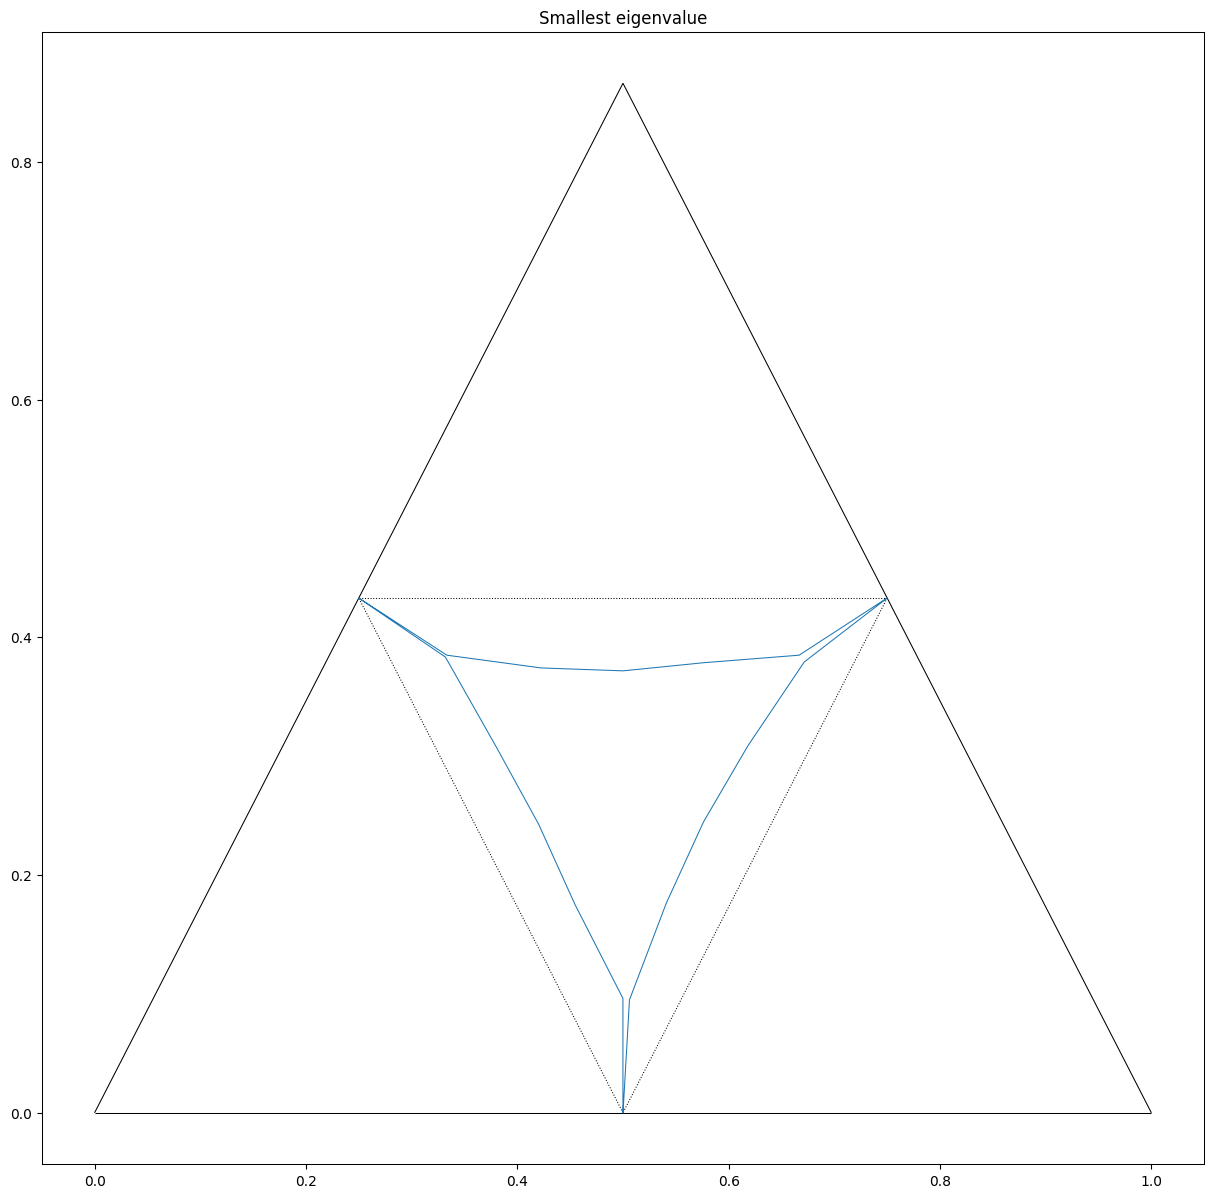

In [94]:
f, axes = plt.subplots(ncols = 1, figsize = (15,15))

ax = axes
ax.set(title = f'Smallest eigenvalue')
pd.plot_triangle(ax)

ax.plot(*project_to_triangle(phase_edge_J).T)

<AxesSubplot:>

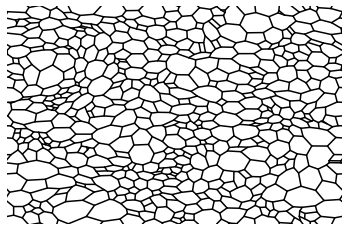

In [7]:
from koala import voronization
from matplotlib import pyplot as plt
from koala import plotting as pl
import numpy as np

fig, ax = plt.subplots()
ax.axis('off')

points = np.random.random((500, 2))
lattice = voronization.generate_lattice(points)

pl.plot_edges(lattice)

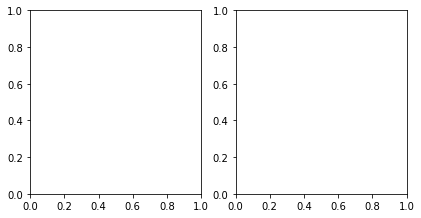

In [10]:
w = 3.375
ncols = 3
fig, (left, right) = plt.subplots(figsize = (2*w,w), ncols = 2)


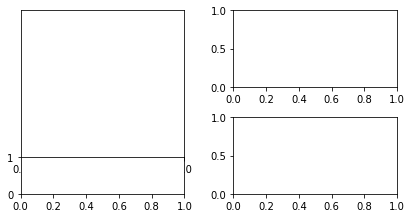

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# gridspec inside gridspec
fig = plt.figure()
fig.set_size_inches(2*w,w)
gs = gridspec.GridSpec(1, 2, figure=fig, wspace = 0.3)

left_gs = gs[0].subgridspec(2, 1, hspace = 0, height_ratios = (8,2))
right_gs = gs[1].subgridspec(2, 1, hspace = 0.4)

edge_mode_ax = fig.add_subplot(left_gs[0])
edge_mode_transect_ax = fig.add_subplot(left_gs[1])

open_bc_DOS_ax = fig.add_subplot(right_gs[0])
closed_bc_DOS_ax = fig.add_subplot(right_gs[1])


edge_mode_ax.set(yticks = [])

plt.show()

In [21]:
Path.mkdir?

Signature: Path.mkdir(self, mode=511, parents=False, exist_ok=False)
Docstring: Create a new directory at this given path.
File:      ~/miniconda3/envs/py3.8/lib/python3.8/pathlib.py
Type:      function


In [50]:
from pathlib import Path
import os
os.chdir("/Users/tom/git/Thesis")

def make_parents(file, src_dir, target_dir, new_extension):
    """Takes a filepath file, makdirs' space for it in target
    dir and returns a path to it with a new extension"""
    parent_relative_to_src = file.relative_to(src_dir).parent
    new_parent = target_dir / parent_relative_to_src
    new_parent.mkdir(parents=True, exist_ok=True)
    return new_parent / (file.stem + new_extension)
    
    
src_dir = Path("./src")
target_dir = Path("./build/markdown")
jupyter_files = src_dir.glob("**/*.ipynb")
for file in jupyter_files:
    if any(p.startswith(".") for p in file.parts): continue
    target = make_parents(file, src_dir, target_dir, new_extension = ".md")
    
    print(file, target)

src/2_Background/2.1_FK_Model.ipynb build/markdown/2_Background/2.1_FK_Model.md
src/2_Background/2.2_HKM_Model.ipynb build/markdown/2_Background/2.2_HKM_Model.md
src/2_Background/2.3_Disorder.ipynb build/markdown/2_Background/2.3_Disorder.md
src/0_Preface/0.1_Aknowledgements.ipynb build/markdown/0_Preface/0.1_Aknowledgements.md
src/1_Introduction/1_Intro.ipynb build/markdown/1_Introduction/1_Intro.md
src/5_Conclusion/5_Conclusion.ipynb build/markdown/5_Conclusion/5_Conclusion.md
src/4_Amorphous_Kitaev_Model/4.2_AMK_Methods.ipynb build/markdown/4_Amorphous_Kitaev_Model/4.2_AMK_Methods.md
src/4_Amorphous_Kitaev_Model/4.1.2_AMK_Model.ipynb build/markdown/4_Amorphous_Kitaev_Model/4.1.2_AMK_Model.md
src/4_Amorphous_Kitaev_Model/4.1_AMK_Model.ipynb build/markdown/4_Amorphous_Kitaev_Model/4.1_AMK_Model.md
src/4_Amorphous_Kitaev_Model/4.3_AMK_Results.ipynb build/markdown/4_Amorphous_Kitaev_Model/4.3_AMK_Results.md
src/3_Long_Range_Falikov_Kimball/3.1_LRFK_Model.ipynb build/markdown/3_Long_Rang

In [86]:
import re

pattern = re.compile(r"(#+)\s+([^{]+)\s*?(\{#sec:[^}]+\})?")

tests = [
    "## section {#sec:blah-blah}",
    "### section      {#sec:blah-blah} ",
    "#### section ",
    "###### section",
]

for test in tests:
    print(test)
    m = re.match(pattern, test)
    level, heading, section_id = m.groups()
    heading = heading.strip()
    level = len(level)
    if section_id is not None: section_id = re.match(r"\{#sec:([^\}]+)\}", section_id).group(1)
    print([level, heading, section_id])
    

## section {#sec:blah-blah}
2 section {#sec:blah-blah}
[2, 'section', 'blah-blah']
### section      {#sec:blah-blah} 
3 section {#sec:blah-blah}
[3, 'section', 'blah-blah']
#### section 
4 section None
[4, 'section', None]
###### section
6 section None
[6, 'section', None]


In [391]:
import pandas as pd
from pathlib import Path
import itertools as it
import numpy as np

with open(Path("~/Downloads/HA_furnace.csv").expanduser()) as f:
    raw_csv_lines = f.readlines()
    
    
header_lines = [item for item in enumerate(raw_csv_lines) if " " not in item[1]]
header_lines.append((len(raw_csv_lines), "N/A"))

In [328]:
data = {}

for i in range(len(header_lines) - 1):
    start, name = header_lines[i]
    name = name.strip()
    end, _ = header_lines[i+1]
    # print(start, end, name)
    # print(raw_csv_lines[start: start+3])
    with open(Path("~/Downloads/HA_furnace.csv").expanduser()) as f:
        data[name] = pd.read_csv(f, header = None, names = ["time", name],
                                 na_values = "unavailable",
                                 parse_dates = True,
                                 index_col = 0,
                                 converters = {1 : lambda s : float(s) if s not in ["unavailable", "unknown"] else float("nan")},
                                 skiprows = start+1, nrows = end - start - 1)
    
# for k, v in data.items():
#     print(k,v,)

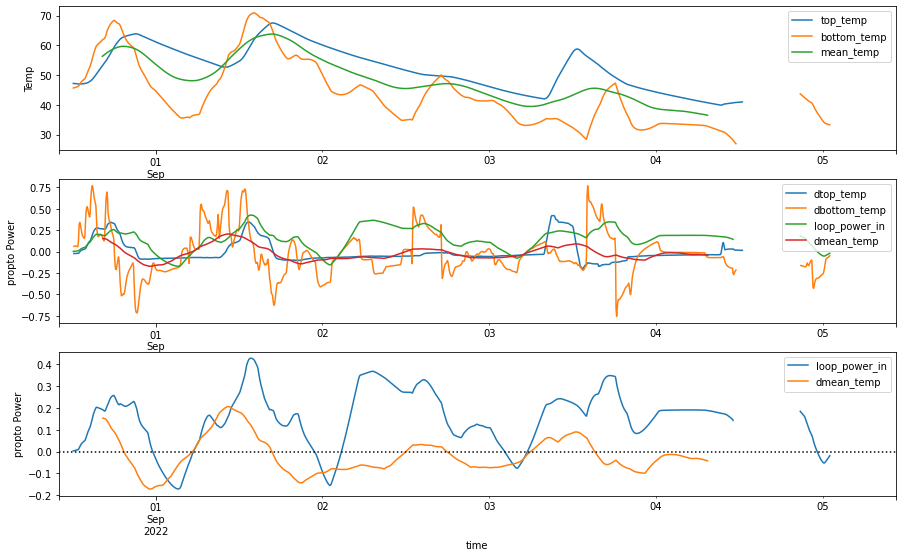

In [697]:
d = pd.DataFrame()
for name, d2 in data.items():
    d2 = d2.resample("5min").mean()
    d = pd.merge(d,d2, how = "outer", left_index = True, right_index = True)

d = d.rename(columns = {
    "sensor.tank_side" : "top_temp",
    "sensor.tank_top" : "shower_out",
    "sensor.boiler_air_temperature": "air",
    "sensor.loop_in" : "in",
    "sensor.loop_out" : "out",
})

tank_capacity_liters = 160
water_specific_heat = 4.182 #Units: kJ / kg / K value varies less than 1% between 20 and 60C, Constant Pressure
kWh_in_kJ = 60*60

d["loop_power_in"] = (d["out"] - d["in"]).rolling(window = 50, center = True).mean() / 50 #this is swapped because I named them wrong orginally

d["top_temp"] = d["top_temp"].rolling(window=50, center = True).mean()
d["bottom_temp"] = d["out"].rolling(window=50, center = True).mean()
d["mean_temp"] = (d["bottom_temp"] + d["top_temp"]) / 2
d["mean_temp"] = d["mean_temp"].rolling(window=100, center = True).mean()

d["dtop_temp"] = d["top_temp"].diff()
d["dbottom_temp"] = d["bottom_temp"].diff()
d["dmean_temp"] = d["mean_temp"].diff()

d["average_temp"] = d["top_temp"]

d["stored_energy"] = (d["average_temp"]) * tank_capacity_liters * water_specific_heat / kWh_in_kJ
d["stored_energy"] = d["stored_energy"].rolling(window = 50, center = True).mean()

d["tank_change"] = d["stored_energy"].diff() * kWh_in_kJ / (5*60) #should be kW

f, (temp_ax, energy_ax, power_ax) = plt.subplots(nrows = 3, figsize = (15,9))

d.plot(ax = temp_ax, y = ["top_temp", "bottom_temp", "mean_temp"], ylabel = "Temp")
d.plot(ax = energy_ax, y = ["dtop_temp", "dbottom_temp", "loop_power_in", "dmean_temp"], ylabel = "propto Power")
d.plot(ax = power_ax, y = ["loop_power_in", "dmean_temp"], ylabel = "propto Power")

power_ax.axhline(y = 0, linestyle = "dotted", color = 'k')



<AxesSubplot:xlabel='time'>

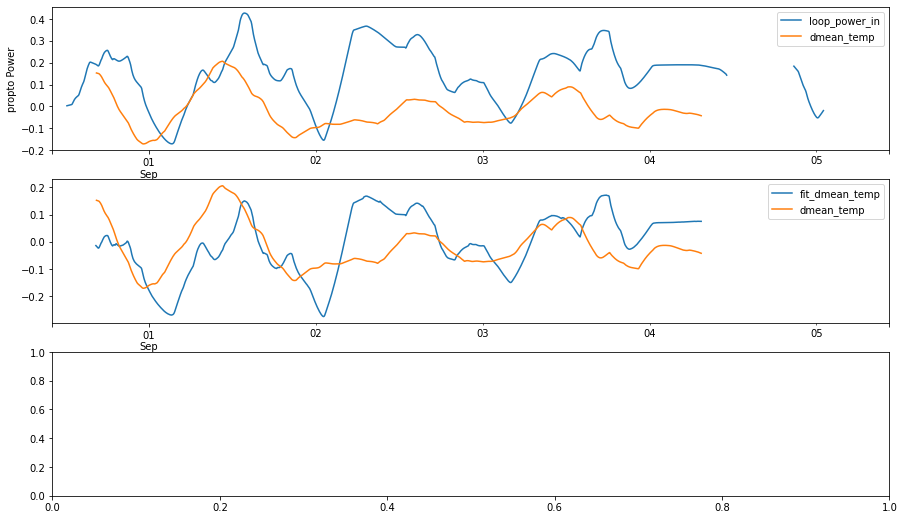

In [713]:
f, axes = plt.subplots(nrows = 3, figsize = (15,9))

d.plot(ax = axes[0], y = ["loop_power_in", "dmean_temp"], ylabel = "propto Power")

power_ax.axhline(y = 0, linestyle = "dotted", color = 'k')

d["fit_dmean_temp"] = 0.8 * d["loop_power_in"] - 0.005 * (d["mean_temp"] - d["air"])

d.plot(ax = axes[1], y = ["fit_dmean_temp", "dmean_temp"])

The model
$$ \frac{dE}{dt} = P_{e} + P_{h} $$

$P_h = C_p R (T_{\mathrm{in}} - T_{\mathrm{out}})$ : Power in or out from the heating loop

$P_e = - \frac{C_p M}{T_0} (T - T_{\mathrm{air}})$ : Power lost to environment

- $M$ : Capacity of the tank kg
- $T_0$ : Time constant for cooling through the wall of the tank s
- $R$ : Mass flow rate of water through the heating loop kg / s
- $C_p$ : Isobaric heat capacity of water J / kg / K
- $ T_{\mathrm{air}}$ : Temperature of the air K



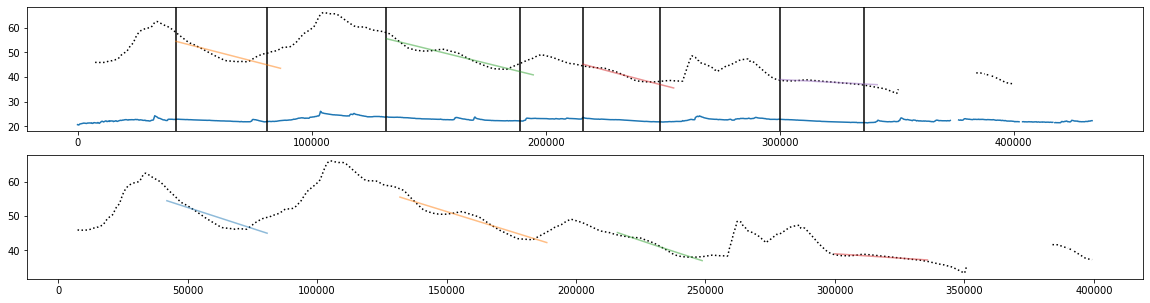

In [630]:
from scipy.optimize import curve_fit

time = d.index.to_numpy().astype(float) / 1e9 #in seconds
time = time - time[0]
temp = d["top_temp"].to_numpy()
temp = d["average_temp"].to_numpy()
air = d["air"].to_numpy()

intervals = [
    [140, 270],
    [440, 630],
    [720, 830],
    [1000, 1120],
]

f, (ax, ax2) = plt.subplots(nrows = 2, figsize = (20, 5))

raw_data = dict(linestyle = "dotted", color = "k")

ax.plot(time, temp, **raw_data)
ax.plot(time, air)
ax2.plot(time, temp, **raw_data)

for l,h in intervals:
    ax.axvline(x = time[l], color = "k")
    ax.axvline(x = time[h], color = "k")

# ax2.plot(time, air)
# ax2.set(xlim = (time[l], time[h]))

    def exponential(t, amplitude, T, offset): return amplitude*np.exp(-t / T) + offset
    popt, pcov = curve_fit(exponential, time[l:h] - time[l], temp[l:h], p0 = [temp[l], 100*60*60, 0])
    dopt = np.sqrt(np.diag(pcov))
    names = ["Amplitude", "T_0", "offset"]

    n = 20
    ax.plot(time[l:h+n], exponential(time[l:h+n] - time[l], *popt), alpha = 0.5)
    ax2.plot(time[l:h], exponential(time[l:h] - time[l], *popt), alpha = 0.5)


300.0
1446 144
loop_mass_flow_rate: 0.01 +- inf
tank_time_constant: 864000.00 +- inf
loop_mass_flow_rate: 0.01 +- 0.00
tank_time_constant: 323589689200.78 +- 153227287679727264.00
loop_mass_flow_rate: -0.01 +- 0.00
tank_time_constant: -385683720710.01 +- 302606175641762752.00
loop_mass_flow_rate: 0.00 +- inf
tank_time_constant: 1813470929940.13 +- inf
loop_mass_flow_rate: -0.01 +- 0.00
tank_time_constant: -631240141106.34 +- 1085059375291760384.00
loop_mass_flow_rate: -0.00 +- 0.00
tank_time_constant: -761024188814.06 +- 435424501043203648.00
loop_mass_flow_rate: -0.01 +- 0.01
tank_time_constant: -25549692731.44 +- 13341072548145920.00
loop_mass_flow_rate: -0.01 +- 0.00
tank_time_constant: -64500349300.85 +- 44885273379989040.00
loop_mass_flow_rate: 0.01 +- inf
tank_time_constant: 864000.00 +- inf
loop_mass_flow_rate: 0.01 +- inf
tank_time_constant: 864000.00 +- inf


/Users/tom/miniconda3/envs/py3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/tom/miniconda3/envs/py3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/tom/miniconda3/envs/py3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/tom/miniconda3/envs/py3.8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


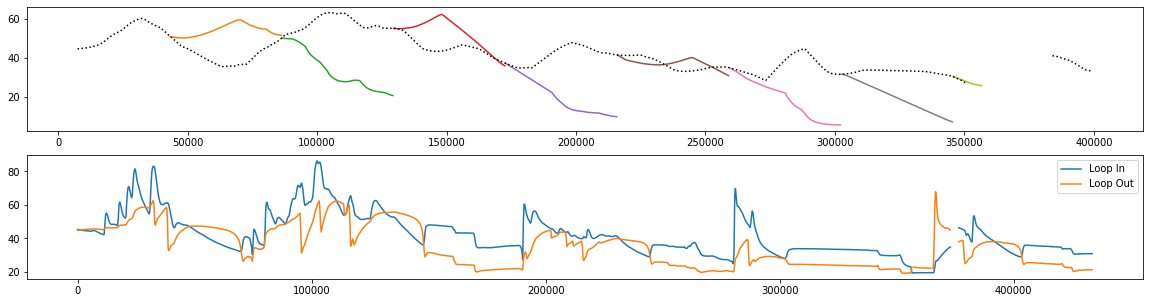

In [684]:
time = d.index.to_numpy().astype(float) / 1e9 #in seconds
time = time - time[0]

# temp_tank = d["top_temp"].to_numpy()
# temp_tank = d["average_temp"].to_numpy()
temp_tank = d["bottom_temp"].to_numpy()

temp_air = d["air"].to_numpy()
temp_loop_in = d["in"].to_numpy()
temp_loop_out = d["out"].to_numpy()

print(time[1] - time[0])

tank_capacity = 160 #kg
water_specific_heat = 4.182 #Units: kJ / kg / K value varies less than 1% between 20 and 60C, Constant Pressure
kWh_in_kJ = 60*60
stored_energy = tank_capacity * water_specific_heat * temp #kJ

P_offset = 0.0
days = 24 * 60 * 60
loop_mass_flow_rate = 0.01
tank_time_constant = 1.32 * days # units: seconds

f, (ax, ax2) = plt.subplots(nrows = 2, figsize = (20, 5))

def dE_by_dt_model(temp_loop_in, temp_loop_out, loop_mass_flow_rate,
                   tank_time_constant, temp_tank, temp_air,
                  ):
    P_h = water_specific_heat * loop_mass_flow_rate * (temp_loop_in - temp_loop_out)
    P_e = - water_specific_heat * tank_capacity / tank_time_constant * (temp_tank - temp_air)
    
    return P_h + P_e + P_offset
    
def model(temp_loop_delta, # x data
          dt, start_temp, temp_air, # fixed inputs
          loop_mass_flow_rate, tank_time_constant, # unknown parameters
         ):
    modelled_tank_temp = np.zeros_like(temp_loop_delta)
    modelled_tank_temp[0] = start_temp
    
    for i in range(modelled_tank_temp.shape[0] - 1):
        modelled_tank_temp[i+1] = modelled_tank_temp[i] \
                      + dt * dE_by_dt_model(temp_loop_delta[i], 0, loop_mass_flow_rate,
                       tank_time_constant, modelled_tank_temp[i], temp_air,
                      ) / (tank_capacity * water_specific_heat)

    return modelled_tank_temp
    
N = 10
step = len(time) // 10
print(len(time), step)
for offset in range(0, len(time), step):
    if offset+step >= len(time): break
    time_slice = time[offset:offset+step]
    
    dt = time_slice[1] - time_slice[0]
    temp_air_mean = temp_air[l:h].mean()
    
    def curried_model(x, *params):
        return model(x, dt, temp_tank[offset], temp_air_mean, # fixed inputs
          *params # unknown parameters
         )
        
    l, h = offset, offset + step
    temp_loop_delta = (temp_loop_in - temp_loop_out)[l:h]
    
    popt, pcov = curve_fit(curried_model, temp_loop_delta, tank_temp[l:h], p0 = [0.01, 10 * days], check_finite = False)
    dopt = np.sqrt(np.diag(pcov))
    names = ["loop_mass_flow_rate", "tank_time_constant"]
    for name, param, error in zip(names, popt, dopt):
        print(f"{name}: {param:.2f} +- {error:.2f}")
    
    fit = curried_model(temp_loop_delta, 0.01, 1000 * days)
    # fit = curried_model(temp_loop_delta,  *popt)
    ax.plot(time_slice, fit)
    
    
ax.plot(time, temp_tank, linestyle = "dotted", color = "k")
ax2.plot(time, temp_loop_out, label = "Loop In")
ax2.plot(time, temp_loop_in, label = "Loop Out")
ax2.legend()

In [637]:
curve_fit?

Signature:
curve_fit(
    f,
    xdata,
    ydata,
    p0=None,
    sigma=None,
    absolute_sigma=False,
    check_finite=True,
    bounds=(-inf, inf),
    method=None,
    jac=None,
    **kwargs,
)
Docstring:
Use non-linear least squares to fit a function, f, to data.

Assumes ``ydata = f(xdata, *params) + eps``.

Parameters
----------
f : callable
    The model function, f(x, ...). It must take the independent
    variable as the first argument and the parameters to fit as
    separate remaining arguments.
xdata : array_like or object
    The independent variable where the data is measured.
    Should usually be an M-length sequence or an (k,M)-shaped array for
    functions with k predictors, but can actually be any object.
ydata : array_like
    The dependent data, a length M array - nominally ``f(xdata, ...)``.
p0 : array_like, optional
    Initial guess for the parameters (length N). If None, then the
    initial values will all be 1 (if the number of parameters for the
    func